# Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?
This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects.
All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as Malmquist bias and was first formulated in 1922.

The goal here is to machine-learn the LIGO detectability: can we predict if a gravitational-wave source will be detected?

This dataset contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the .h5 format is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with h5py.

In particular, each source has the following features:

- mtot: the total mass of the binary
- q: the mass ratio
- chi1x, chi1y, chi1z, chi2x, chi2y, chi2z: the components of the black-hole spins in a suitable reference frame.
- ra, dec: the location of the source in the sky
- iota: the inclination of the orbital plane'
- psi: the polarization angle (gravitational waves have two polarization states much like light)
- z: the redshift

The detectability is defined using the snr (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in the gravitational-wave class; see here for a nice write-up. All you need to know now is that we threshold the snr values and assume that LIGO will (not) see a source if snr>12 (snr<12). The resulting 0-1 labels are reported in the det attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't.

Be creative! This is a challenge! Let's see who gets the higher completeness and/or the smaller contamination (on a validation set, of course, careful with overfitting here).

Tips:

- You can downsample the data for debugging purposes
- You can also use only some of the features.
- Plot ROC curves
- Important Don't use snr as feature in your classifer (that's the answer...)

Other ideas (optional)
- Using the same data, we could run a regressor on snr instead of a classifier on det. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

In [34]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import h5py
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
file_path = '/home/sara/sample_2e7_design_precessing_higherordermodes_3detectors.h5'
# Open the HDF5 file in read-only mode and print the main keys
with h5py.File(file_path, 'r') as f:
    print("Main Keys", list(f.keys()))


Main Keys ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']


In [10]:
# Open the HDF5 file again and read specific datasets into numpy arrays
n = int(1e5)
with h5py.File(file_path, 'r') as f:
    mtot = f['mtot'][:n]
    q = f['q'][:n]
    chi1x = f['chi1x'][:n]
    chi1y = f['chi1y'][:n]
    chi1z = f['chi1z'][:n]
    chi2x = f['chi2x'][:n]
    chi2y = f['chi2y'][:n]
    chi2z = f['chi2z'][:n]
    ra = f['ra'][:n]
    dec = f['dec'][:n]
    iota = f['iota'][:n]
    psi = f['psi'][:n]
    z = f['z'][:n]
    det = f['det'][:n] 
    snr = f['snr'][:n]    


In [11]:
matrix = np.stack([mtot, q, chi1x, chi1y, chi1z,chi2x, chi2y, chi2z,ra, dec,iota, psi,z], axis=1)
columns = ['mtot', 'q', 'chi1x', 'chi1y', 'chi1z',
           'chi2x', 'chi2y', 'chi2z', 'ra', 'dec',
           'iota', 'psi', 'z']

df = pd.DataFrame(matrix, columns=columns)
df


,mtot,q,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,ra,dec,iota,psi,z
0,906.803562,0.624780,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-3.116784,-0.329671,1.809310,1.286031,2.139659
1,59.102112,0.986650,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,1.360291,0.526740,0.820820,0.934308,2.438707
2,44.602750,0.286199,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.079973,0.315799,2.008206,1.535520,1.869461
3,534.378032,0.538882,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,-1.780558,0.432105,2.018398,3.064086,0.428061
4,573.821705,0.846310,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,2.789289,-0.458711,2.037363,0.752211,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,326.220322,0.802986,-0.710484,0.203788,-0.030539,-0.194861,0.014570,-0.054834,1.273264,-0.239913,1.905192,1.473113,1.901201
99996,403.949547,0.386258,0.804222,0.086352,0.550408,0.181968,0.824057,0.412858,-1.279446,0.195437,1.920145,0.184597,1.491419
99997,884.399749,0.722733,0.652722,-0.022264,0.132145,0.272847,0.381442,0.773596,0.444194,-0.584279,2.637491,1.601521,0.735589
99998,949.832616,0.459489,-0.134977,0.016409,-0.207572,-0.100090,0.117877,0.054799,-0.415330,0.754165,1.147342,0.060168,0.394833


In [12]:
X = matrix
y = det
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to reduce dimensionality (keep 95% variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 13
Reduced number of features after PCA: 13


All 13 original features were needed to explain 95% of the variance. This indicates that the dataset’s features are all informative and not highly redundant, so we keep all features for modeling.

## Decision Tree Classifier

In [26]:
# Create a Decision Tree classifier with a maximum depth of 7 and entropy as the splitting criterion
clf = DecisionTreeClassifier(random_state=0, max_depth=7,criterion='entropy')
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=0)

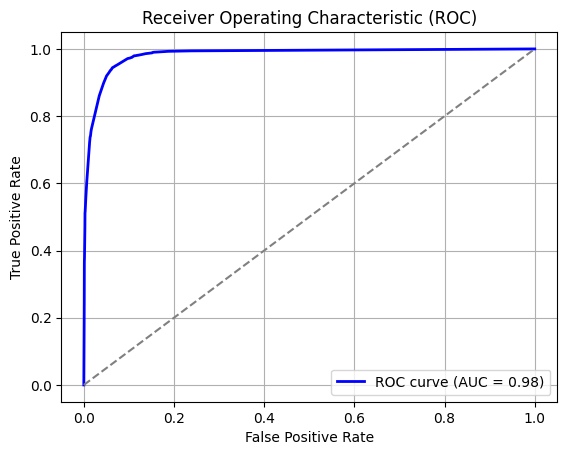

Completeness: 0.77
Contamination: 0.12


In [27]:
y_proba = clf.predict_proba(X_test)[:, 1] # Get predicted probabilities for the positive class
# Compute fpr,tpr and auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()
print(f"Completeness: {completeness:.2f}")
print(f"Contamination: {contamination:.2f}")

##  Decision Tree Regressor

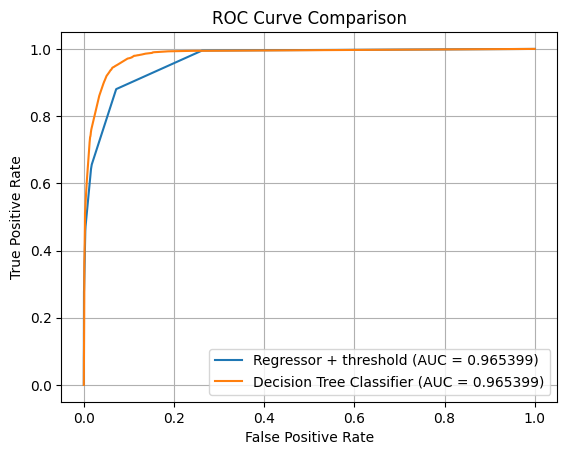

Completeness: 0.88
Contamination: 0.33


In [37]:
# X are the features and snr is the continuous target for regression
X_train, X_test, snr_train, snr_test = train_test_split(X, snr, test_size=0.3, random_state=42)
regressor = DecisionTreeRegressor(max_depth=7, random_state=0) 
regressor.fit(X_train, snr_train) # The regressor will learn to predict continuous SNR values from features
snr_pred = regressor.predict(X_test)

y_pred = (snr_pred >= 12).astype(int) #snr >= 12 means detected
y_true = (snr_test >= 12).astype(int) # original dataset

fpr_reg, tpr_reg, _ = roc_curve(y_true, snr_pred)
auc_reg = auc(fpr_reg, tpr_reg)
# Plot the ROC curve for the regressor + threshold method
plt.plot(fpr_reg, tpr_reg, label=f'Regressor + threshold (AUC = {auc_reg:.6f})')
# Plot the ROC curve for the Decision Tree Classifier method
plt.plot(fpr, tpr, label=f'Decision Tree Classifier (AUC = {roc_auc:.6f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
completeness = tp / (tp + fn)
contamination = fp / (tp + fp)

print(f"Completeness: {completeness:.2f}")
print(f"Contamination: {contamination:.2f}")

### Classifier vs regressor: same AUC, different outcomes

In this analysis, we compared a decision tree classifier and a decision tree regressor (with thresholding at snr ≥ 12). Both models achieved a similar ROC AUC, but their performance in terms of completeness and contamination was quite different

This difference arises because ROC AUC measures how well a model ranks positive examples above negative ones across all possible thresholds. It does not depend on any fixed decision threshold.
The regressor, when applying a fixed threshold (snr ≥ 12), tends to be more inclusive. This leads to higher completeness (more true positives), but also higher contamination (more false positives).
The classifier, on the other hand, is trained to directly separate detectable from non-detectable sources. As a result, it tends to be more conservative, achieving lower contamination at the cost of missing some true positives.



## Random Forest Classifier

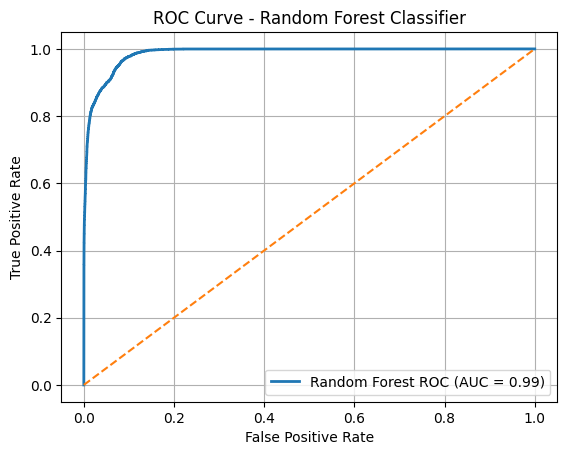

Completeness: 0.82
Contamination: 0.11


In [32]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=7, criterion='entropy',n_jobs=-1) # Train a Random Forest classifier
rf_clf.fit(X_train, y_train)

y_proba_rf = rf_clf.predict_proba(X_test)[:, 1] # Predict class 1 probabilities
y_pred_rf = rf_clf.predict(X_test) # Predict class labels

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest ROC (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
completeness_rf = tp / (tp + fn)
contamination_rf = fp / (tp + fp)

print(f"Completeness: {completeness_rf:.2f}")
print(f"Contamination: {contamination_rf:.2f}")

## Boosting

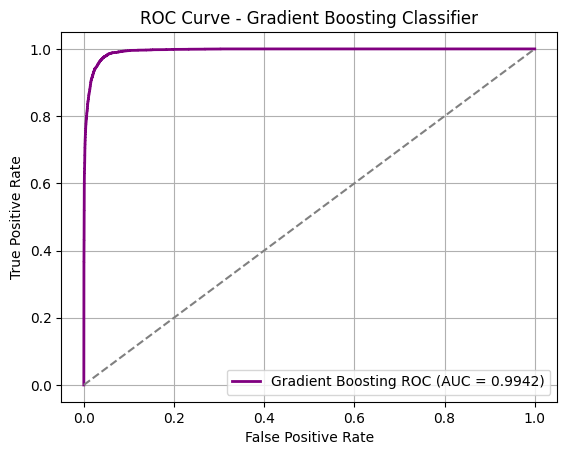

Completeness: 0.89
Contamination: 0.09


In [39]:
# Create a Gradient Boosting classifier with n_estimators=number of boosting stages
gb_clf = GradientBoostingClassifier(n_estimators=150,learning_rate=0.05,max_depth=7,random_state=42)
gb_clf.fit(X_train, y_train)


y_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
y_pred_gb = gb_clf.predict(X_test)


fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, color='purple', lw=2, label=f'Gradient Boosting ROC (AUC = {roc_auc_gb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


tn, fp, fn, tp = confusion_matrix(y_test, y_pred_gb).ravel()
completeness_gb = tp / (tp + fn)
contamination_gb = fp / (tp + fp)

print(f"Completeness: {completeness_gb:.2f}")
print(f"Contamination: {contamination_gb:.2f}")


### Summary of model performance

The best results were achieved with Random Forest and Gradient Boosting classifiers. Gradient Boosting can provide slightly better accuracy but is much more computationally intensive. Therefore, Random Forest is often a good compromise between performance and speed.

